In [1]:
import pickle 
import numpy as np
import os 
import matplotlib.pyplot as plt

deposited_pdb_folder = "/home/abharadwaj1/papers/elife_paper/figure_information/data/deposited_atomic_models/"

# Get all the pdb files in the deposited_pdb_folder
pdb_files = [os.path.join(deposited_pdb_folder,x) for x in os.listdir(deposited_pdb_folder) if x.endswith('.pdb')]


In [2]:
from locscale.include.emmer.pdb.pdb_to_map import pdb2map
from locscale.include.emmer.pdb.pdb_utils import set_atomic_bfactors
from locscale.include.emmer.ndimage.profile_tools import compute_radial_profile, frequency_array
from tqdm import tqdm
import joblib
import gemmi
def get_radial_profile(pdb_file):
    pdb_id = os.path.basename(pdb_file).split('_')[1]
    # Get the map
    st = gemmi.read_structure(pdb_file)
    zero_bfactor_st = set_atomic_bfactors(input_gemmi_st=st, b_iso=0)
    simmap = pdb2map(zero_bfactor_st, apix=1.5, size=(250,250,250))
    # Get the radial profile
    rp = compute_radial_profile(simmap)
    return (rp, pdb_id)




In [3]:

radial_profiles_pdb = {}

results = joblib.Parallel(n_jobs=10)(joblib.delayed(get_radial_profile)(pdb_file) for pdb_file in tqdm(pdb_files))


100%|██████████| 126/126 [02:17<00:00,  1.09s/it]


In [4]:

for rp, pdb_id in results:
    radial_profiles_pdb[pdb_id] = rp
    
freq = frequency_array(rp, apix=1.5)

NEW FUNCTION


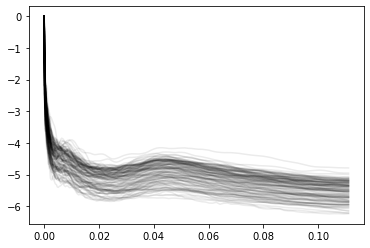

In [5]:
for rp in radial_profiles_pdb.values():
    rp = rp/np.max(rp)
    plt.plot(freq**2, np.log(rp), alpha=0.08, color='black')


In [6]:
peak_freq_squared = 0.04
peak_freq = np.sqrt(peak_freq_squared)
peak_res = 1/peak_freq
print(f"Peak resolution: {peak_res:.2f} A")

Peak resolution: 5.00 A


NEW FUNCTION


([<matplotlib.axis.XTick at 0x7fcc353d1590>,
 [Text(0, 0, ''), Text(0, 0, '')])

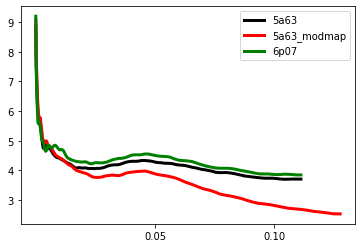

In [7]:
from locscale.include.emmer.ndimage.map_utils import load_map
from locscale.include.emmer.ndimage.profile_tools import compute_radial_profile, frequency_array
modmap_path = "/home/abharadwaj1/papers/elife_paper/figure_information/data/maps/emd_3061/model_based/processing_files/5a63_shifted_servalcat_refined_shifted_bfactors..m_4locscale.mrc"
modmap, apix = load_map(modmap_path)
rp_modmap = compute_radial_profile(modmap)
freq_modmap = frequency_array(rp_modmap, apix=apix)

plt.plot(freq**2, np.log(radial_profiles_pdb["5a63"]), color='black', linewidth=3, label="5a63")
plt.plot(freq_modmap**2, np.log(rp_modmap), color='red', linewidth=3, label="5a63_modmap")
random_pdb_id = np.random.choice(list(radial_profiles_pdb.keys()))
random_rp = radial_profiles_pdb[random_pdb_id]
plt.plot(freq**2, np.log(random_rp), color='green', linewidth=3, label=random_pdb_id)
plt.legend()
# show only 0.05 and 0.1 in the x-axis
plt.xticks([0.05, 0.1])


([<matplotlib.axis.XTick at 0x7fcc35364bd0>,
 [Text(0, 0, ''), Text(0, 0, '')])

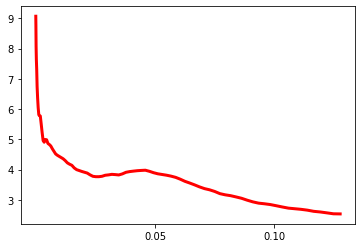

In [8]:
plt.plot(freq_modmap**2, np.log(rp_modmap), color='red', linewidth=3, label="5a63_modmap")
plt.xticks([0.05, 0.1])

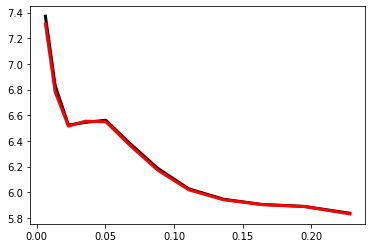

In [9]:
import pickle
from locscale.include.emmer.ndimage.profile_tools import resample_1d
from locscale.utils.file_tools import get_locscale_path
import os
profile_type = "helix"
length = 12
apix = 1.0470000902811687

path_to_locscale = get_locscale_path()
location_of_theoretical_profiles = os.path.join(path_to_locscale, "locscale","utils","theoretical_profiles.pickle")

with open(location_of_theoretical_profiles,'rb') as f:
    profiles = pickle.load(f)

frequency_limits = (float(1/(apix*length)),float(1/(apix*2)))
helix_profile = profiles[profile_type]
freq_old = helix_profile['freq']
rp = helix_profile['profile']
freq_new = np.linspace(freq_old[0]/2, freq_old[-1], num=len(freq_old), endpoint=True)
resampled_helix_profile_old = resample_1d(freq_old, helix_profile['profile'],num=length,xlims=frequency_limits)
resampled_helix_profile_new = resample_1d(freq_new, helix_profile['profile'],num=length,xlims=frequency_limits)

resampled_freq_old = resampled_helix_profile_old[0]
resampled_rp_old = resampled_helix_profile_old[1]
resampled_freq_new = resampled_helix_profile_new[0]
resampled_rp_new = resampled_helix_profile_new[1]
plt.plot(resampled_freq_old**2, np.log(resampled_rp_old), color='black', linewidth=3, label="old")
plt.plot(resampled_freq_new**2, np.log(resampled_rp_new), color='red', linewidth=3, label="new")